## Food item modeling
The Branded food items are not labeled or categorized but have an ingredients list provided by the manufacturer.  The ingredients in a food label is an ordered listed in *decreasing order by weight*.  
* For a simple categorization method, observe how item similarities change as the number of elements (ingredients) are successively increased
E.g. use the first 5 items to calculate cosine similarity for each food item, then cluster.  

In [356]:
%matplotlib inline

In [575]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import re
import string
import pickle
import matplotlib.pyplot as plt
import collections
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

In [1]:
# Retrieve pickled standard reference food items (175228 total)
with open("../../../food_data/br_food_items_list","r") as f: 
    food_items = pickle.load(f)

In [112]:
# Food item IDs, names, and their ingredients
food_items[:5]

[(u'45001524',
  u'MOCHI ICE CREAM BONBONS, UPC: 019022128593',
  u'ICE CREAM INGREDIENTS: MILK, CREAM, SUGAR, STRAWBERRIES (STRAWBERRIES, SUGAR), CORN SYRUP SOLIDS, SKIM MILK, WHEY, NATURAL FLAVOR, GUAR GUM, MONO & DIGLYCERIDES, BEET JUICE AND BEET POWDER (FOR COLOR), CELLULOSE GUM, LOCUST BEAN GUM, CARRAGEENAN. COATING INGREDIENTS: SUGAR, WATER, RICE FLOUR, TREHALOSE, EGG WHITES, BEET JUICE AND BEET POWDER (FOR COLOR), DUSTED WITH CORN & POTATO STARCH'),
 (u'45001528',
  u'CHIPOTLE BARBECUE SAUCE, UPC: 5051379043735',
  u'WATER, SUGAR, TOMATO PASTE, MOLASSES, DISTILLED VINEGAR, CONTAINS 2% OR LESS OF: CORN STARCH, SALT, DRIED CHIPOTLE PEPPER, NATURAL SMOKE FLAVOR, MUSTARD FLOUR, DRIED GARLIC, DRIED ONION, SPICES.'),
 (u'45001529',
  u'BARBECUE SAUCE, UPC: 5051379009434',
  u'SUGAR, WATER, DISTILLED VINEGAR, TOMATO PASTE, MOLASSES MODIFIED CORN STARCH, SALT, PINEAPPLE JUICE CONCENTRATE, CONTAINS 1% OR LESS OF: JALAPENO PEPPERS, SPICE, CARAMEL COLOR, NATURAL FLAVOR, XANTHAN GUM, GARLIC

In [219]:
# isolate the ingredients list from food_items
ingredients_list = [a[2] for a in food_items]

## Parsing individual ingredients from `ingredients_list`

In [344]:
# Obtain the first ingredient of each food item.
# First pass: Split on commas and evaluate
# Without stemming or further processing, this reduces the list to .16 of origina
first_ingredient = [a.split(',')[0] for a in ingredients_list]

print "count of all first terms:", len(first_ingredient)
print "count of unique terms:", len(set(first_ingredient))
print "ratio: {}".format(1.*len(set(first_ingredient))/len(first_ingredient))

count of all first terms: 175228
count of unique terms: 28208
ratio: 0.160978838998


In [348]:
# It is observed that there are many ingredients lists are not separated by commas: 
# periods, hyphens, semicolons, forward slashes, or no punctuation at all (spaces) are used
# There are also ingredients lists split into sub-components, either enclosed 
# in parentheses or following a semicolon.  
# View some samples: 
[a for a in first_ingredient if len(a.split()) > 10][:10]

[u'ORGANIC ENRICHED PETITE PASTA SHELLS [ORGANIC DURUM WHEAT SEMOLINA FLOUR (NIACIN',
 u'MADE WITH ROASTED PEANUTS AND SUGAR. CONTAINS 2% OR LESS OF MOLASSES',
 u'ORGANIC CULTURED PASTEURIZED REDUCED FAT MILK. LIVE ACTIVE CULTURES: L. ACIDOPHILUS',
 u'PASTEURIZED AND CULTURED ORGANIC SOYMILK (FILTERED WATER AND GROUND ORGANIC SOYBEANS)',
 u'CULTURED PASTEURIZED GRADE A LOWFAT MILK AND NONFAT MILK SOLIDS. CONTAINS ACTIVE YOGURT CULTURES.',
 u'TURBINADO SUGAR; WHOLE WHEAT PASTRY FLOUR; COCOA; MILLED FLAX SEED; SALT.',
 u'CANE SUGAR*; **COCOA*; CHOCOLATE*; CINNAMON*; CAYENNE PEPPER*; MILK*(LESS THAN0. 1%). *ORGANIC',
 u'IDAHO POTATOES* WITH EMULSIFIER (MONO & DIGLYCERIDES) AND PRESERVATIVES (SODIUM ACID PYROPHOSPHATE',
 u'RAVIOLI INGREDIENTS: ENRICHED EXTRA FANCY DURUM FLOUR AND SEMOLINA (DURUM WHEAT FLOUR',
 u'CASSIA ACUTIFOLIA DELILE (SENNA LEAF); FOLIUM SENNAE; TINNEVELLY SENNA; CASSIA ANGUSTIFOLIA VAHL.']

In [416]:
# Get count of all punctuations in ingredients list
all_punctuation_counter = collections.Counter(re.findall(r'[!"#$%&\\\'()*+,-./:;<=>?@\[\]^_`{|}~\']', 
                                                         " ".join(ingredients_list)))
all_punctuation_counter.most_common()

[(u',', 1767190),
 (u'(', 237166),
 (u')', 219593),
 (u'.', 149518),
 (u':', 42010),
 (u'[', 36531),
 (u'%', 35382),
 (u']', 33167),
 (u'*', 31914),
 (u'-', 25488),
 (u'&', 17422),
 (u'/', 16643),
 (u'#', 9427),
 (u';', 4690),
 (u"'", 4684),
 (u'{', 3074),
 (u'}', 2786),
 (u'+', 1364),
 (u'"', 419),
 (u'_', 207),
 (u'>', 184),
 (u'!', 169),
 (u'<', 150),
 (u'?', 55),
 (u'=', 20),
 (u'|', 11),
 (u'\\', 7),
 (u'$', 6),
 (u'@', 5),
 (u'`', 2)]

In [417]:
# Frequency of punctuation occurrences for each ingredient list.  
punctuation_counter = []
for a in ingredients_list: 
    punctuation_counter.append(collections.Counter(re.findall(r'[!"#$%&\\\\\'()*+,-./:;<=>?@\[\]^_`{|}~\']', 
                                                              a)).most_common() 

In [419]:
# Frequency of most frequent punctuation per food item 
#  (punctuations with highest frequency in list is most likely the separator). 
collections.Counter([a[0][0] for a in punctuation_counter if len(a)!=0]).most_common()

[(u',', 156262),
 (u'.', 8999),
 (u')', 1979),
 (u'%', 1297),
 (u'*', 1250),
 (u':', 445),
 (u'-', 372),
 (u';', 329),
 (u'/', 91),
 (u'+', 55),
 (u'&', 46),
 (u'(', 35),
 (u'#', 33),
 (u'"', 22),
 (u"'", 17),
 (u'!', 16),
 (u'[', 6),
 (u']', 1),
 (u'}', 1),
 (u'|', 1)]

In [444]:
ingredients_list[0]

u'ICE CREAM INGREDIENTS: MILK, CREAM, SUGAR, STRAWBERRIES (STRAWBERRIES, SUGAR), CORN SYRUP SOLIDS, SKIM MILK, WHEY, NATURAL FLAVOR, GUAR GUM, MONO & DIGLYCERIDES, BEET JUICE AND BEET POWDER (FOR COLOR), CELLULOSE GUM, LOCUST BEAN GUM, CARRAGEENAN. COATING INGREDIENTS: SUGAR, WATER, RICE FLOUR, TREHALOSE, EGG WHITES, BEET JUICE AND BEET POWDER (FOR COLOR), DUSTED WITH CORN & POTATO STARCH'

In [448]:
re.split?

In [449]:
# Use regular expressions to split ingredients_list by all relevant separators
pattern = re.compile(r'[.,;]|/| - |\*')
list1 = [re.split(pattern, a.lower()) for a in ingredients_list]

In [450]:
list1[:5]

[[u'ice cream ingredients: milk',
  u' cream',
  u' sugar',
  u' strawberries (strawberries',
  u' sugar)',
  u' corn syrup solids',
  u' skim milk',
  u' whey',
  u' natural flavor',
  u' guar gum',
  u' mono & diglycerides',
  u' beet juice and beet powder (for color)',
  u' cellulose gum',
  u' locust bean gum',
  u' carrageenan',
  u' coating ingredients: sugar',
  u' water',
  u' rice flour',
  u' trehalose',
  u' egg whites',
  u' beet juice and beet powder (for color)',
  u' dusted with corn & potato starch'],
 [u'water',
  u' sugar',
  u' tomato paste',
  u' molasses',
  u' distilled vinegar',
  u' contains 2% or less of: corn starch',
  u' salt',
  u' dried chipotle pepper',
  u' natural smoke flavor',
  u' mustard flour',
  u' dried garlic',
  u' dried onion',
  u' spices',
  u''],
 [u'sugar',
  u' water',
  u' distilled vinegar',
  u' tomato paste',
  u' molasses modified corn starch',
  u' salt',
  u' pineapple juice concentrate',
  u' contains 1% or less of: jalapeno peppe

In [451]:
# Splitting with relevant separators improves consolidation (again, without 
# additional preprocessing/tokenization): 
first_list1 = [a[0] for a in list1]
print "count of all first terms:", len(first_list1)
print "count of unique terms:", len(set(first_list1))
print "ratio: {}".format(1.*len(set(first_list1))/len(first_list1))

count of all first terms: 175228
count of unique terms: 25064
ratio: 0.143036501016


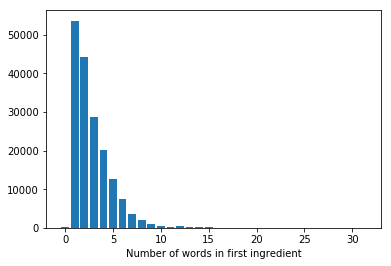

In [452]:
# Observe how many words are in the first ingredient: 
num_words_first = [len(a.split()) for a in first_list1]
counter_first_list1 = collections.Counter(num_words_first)

plt.bar(list(counter_first_list1.keys()), counter_first_list1.values()) 
plt.xlabel("Number of words in first ingredient")
plt.show()

This shows that, even if length of ingredient names are limited to three words or less, there are still ~120000 food items that is parsed into a valid ingredients (based on this criterion).  

In [453]:
# Observe sample of terms of various lengths in the first ingredient
for a in counter_first_list1.keys(): 
    index = [k for k,v in enumerate(num_words_first) if v ==a][0]
    print "\nnumber of words: {}, index: {} \n{}".format(a, index, first_list1[index])


number of words: 0, index: 148 


number of words: 1, index: 1 
water

number of words: 2, index: 3 
tomato puree(water

number of words: 3, index: 9 
organic grain vinegar

number of words: 4, index: 0 
ice cream ingredients: milk

number of words: 5, index: 27 
prepared dark red kidney beans

number of words: 6, index: 106 
parmesan cheese (pasteurized part-skim cow's milk

number of words: 7, index: 157 
enriched macaroni (durum and enriched wheat flour

number of words: 8, index: 334 
blueberries & oats  unbleached wheat flour ( flour

number of words: 9, index: 846 
enriched macaroni product (durum and wheat flour with niacin

number of words: 10, index: 900 
cultured pasteurized grade a lowfat milk and nonfat milk solids

number of words: 11, index: 159 
organic enriched petite pasta shells [organic durum wheat semolina flour (niacin

number of words: 12, index: 1148 
ravioli ingredients: enriched extra fancy durum flour and semolina (durum wheat flour

number of words: 13, inde

- Based on the above observation, some lengthy ingredients are due to lists with no punctuation.  These exceptions are difficult to resolve without a more intensive processes.  
- Ingredient items that include more detailed punctuation-separated ingredients enclosed parentheses/brackets will be cut off after the first detailed ingredient.  This is an ok compromise as it captures at least the main ingredient.  

It is apparent that an exhaustive parsing of ingredients would be a time-consuming task to be done as necessary in future iterations.  

---

## `Use CountVectorizer` to create document term matrix

In [454]:
# Words to remove: ['ingredients', 'ingredient', ...] -- include in stop_words
from sklearn.feature_extraction import text 
stop_words = text.ENGLISH_STOP_WORDS.union('ingredients','ingredient')

In [590]:
# Create vectorizer 
cvectorizer = CountVectorizer(min_df=5, strip_accents="ascii", stop_words='english')

In [591]:
# dtm for entire corpus
dtm = cvectorizer.fit_transform([" ".join(a) for a in list1])

In [482]:
dtm.shape

(175228, 4994)

In [585]:
cvectorizer.vocabulary_

{u'vani': 4774,
 u'bromelain': 682,
 u'tapioc': 4511,
 u'albumen': 213,
 u'propane': 3665,
 u'pigment': 3477,
 u'hydrolyzate': 2349,
 u'caramels': 807,
 u'probiotic': 3649,
 u'wholemeal': 4906,
 u'solid': 4198,
 u'isomaltulose': 2439,
 u'specially': 4251,
 u'270': 47,
 u'amylases': 282,
 u'cooking': 1233,
 u'glyco': 2108,
 u'glyce': 2099,
 u'wheatgrass': 4889,
 u'china': 989,
 u'wagyu': 4857,
 u'sriracha': 4293,
 u'pleurotus': 3515,
 u'golden': 2120,
 u'derivatives': 1439,
 u'dusting': 1571,
 u'standardized': 4307,
 u'nitrates': 3111,
 u'titanium': 4612,
 u'pinto': 3493,
 u'wholewheat': 4908,
 u'italy': 2442,
 u'jaggery': 2448,
 u'season': 4033,
 u'yellowfin': 4967,
 u'plantains': 3512,
 u'folate': 1920,
 u'fib': 1829,
 u'fig': 1836,
 u'oligosaccharide': 3201,
 u'hawthorn': 2245,
 u'palminate': 3269,
 u'proce': 3652,
 u'honeybee': 2295,
 u'lupini': 2696,
 u'thyme': 4595,
 u'arrow': 353,
 u'stabiliser': 4296,
 u'emulsifier': 1679,
 u'grapefruits': 2153,
 u'turnip': 4716,
 u'emulsified':

In [459]:
# sums up the term frequencies for all tokens
dtm.sum(axis=0)

matrix([[  27,   11,   25, ..., 2276,    6,  413]])

Order branded food items according to the amount of common ingredients they have. 

In [488]:
# Show ingredient terms ordered by frequency 

sorted(zip(cvectorizer.get_feature_names(), 
           np.asarray(dtm.sum(axis=0)).ravel()), 
       key=lambda x:x[1], 
       reverse=True)

[(u'salt', 137344),
 (u'sugar', 108814),
 (u'oil', 99586),
 (u'acid', 98236),
 (u'water', 93660),
 (u'flour', 82941),
 (u'organic', 77295),
 (u'corn', 77257),
 (u'milk', 70270),
 (u'natural', 66932),
 (u'wheat', 60386),
 (u'sodium', 55564),
 (u'syrup', 50414),
 (u'flavor', 47558),
 (u'powder', 41026),
 (u'starch', 39584),
 (u'citric', 39528),
 (u'soy', 38292),
 (u'gum', 36073),
 (u'vitamin', 35304),
 (u'juice', 33849),
 (u'color', 32214),
 (u'contains', 31372),
 (u'garlic', 30284),
 (u'soybean', 29961),
 (u'artificial', 29441),
 (u'cheese', 29191),
 (u'red', 26492),
 (u'vinegar', 25046),
 (u'riboflavin', 24916),
 (u'lecithin', 24721),
 (u'flavors', 24636),
 (u'folic', 24472),
 (u'palm', 24218),
 (u'concentrate', 24162),
 (u'modified', 23859),
 (u'niacin', 23818),
 (u'mononitrate', 23805),
 (u'iron', 23379),
 (u'extract', 22937),
 (u'cocoa', 22907),
 (u'butter', 21980),
 (u'vegetable', 21930),
 (u'enriched', 21591),
 (u'calcium', 21447),
 (u'onion', 21326),
 (u'spices', 20609),
 (u'crea

---
The following iterations of `cvectorizer` is to observe how the frequencies change as you expand the corpus from first ingredient to third, fifth, tenth ingredients for each food item.  

In [579]:
# Get first ingredient
first_list1 = [a[0] for a in list1]
first_dtm = cvectorizer.fit_transform(first_list1)

In [580]:
firstingredient_terms = \
sorted(zip(cvectorizer.get_feature_names(), 
           np.asarray(first_dtm.sum(axis=0)).ravel()), 
       key=lambda x:x[1], 
       reverse=True)

In [572]:
three_list1 = [" ".join(a[:3]) for a in list1]

three_dtm = cvectorizer.fit_transform(three_list1)

threeingredients_terms = \
sorted(zip(cvectorizer.get_feature_names(), 
           np.asarray(three_dtm.sum(axis=0)).ravel()), 
       key=lambda x:x[1], 
       reverse=True)

In [573]:
five_list1 = [" ".join(a[:5]) for a in list1]
five_dtm = cvectorizer.fit_transform(five_list1)
fiveingredients_terms = \
sorted(zip(cvectorizer.get_feature_names(), 
           np.asarray(five_dtm.sum(axis=0)).ravel()), 
       key=lambda x:x[1], 
       reverse=True)

In [574]:
ten_list1 = [" ".join(a[:10]) for a in list1]
ten_dtm = cvectorizer.fit_transform(ten_list1)
teningredients_terms = \
sorted(zip(cvectorizer.get_feature_names(), 
           np.asarray(ten_dtm.sum(axis=0)).ravel()), 
       key=lambda x:x[1], 
       reverse=True)

In [593]:

all_terms = \
sorted(zip(cvectorizer.get_feature_names(), 
       np.asarray(dtm.sum(axis=0)).ravel()), 
       key=lambda x:x[1], 
       reverse=True)

In [615]:
pd.DataFrame([firstingredient_terms[:10], 
              threeingredients_terms[:10], 
              fiveingredients_terms[:10], 
              teningredients_terms[:10], 
             all_terms[:10]], 
             index=['one_ingredient', 
                    'three_ingredients', 
                    'five_ingredients', 
                    'ten_ingredients', 
                    'all_ingrdients'])

,0,1,2,3,4,5,6,7,8,9
one_ingredient,"(flour, 31980)","(water, 26866)","(wheat, 23347)","(milk, 19667)","(sugar, 18280)","(organic, 14268)","(enriched, 12913)","(pasteurized, 9449)","(corn, 8007)","(cultured, 5144)"
three_ingredients,"(water, 57154)","(flour, 50920)","(sugar, 48610)","(wheat, 33589)","(organic, 32668)","(milk, 29415)","(corn, 27210)","(oil, 26762)","(salt, 26227)","(syrup, 20825)"
five_ingredients,"(water, 65400)","(sugar, 62269)","(flour, 57158)","(salt, 48389)","(organic, 45384)","(oil, 39950)","(milk, 38729)","(wheat, 38125)","(corn, 37641)","(syrup, 28365)"
ten_ingredients,"(salt, 88445)","(sugar, 87903)","(water, 81210)","(oil, 71697)","(flour, 69249)","(organic, 65673)","(acid, 64868)","(corn, 55034)","(milk, 52313)","(wheat, 46823)"
all_ingrdients,"(salt, 137344)","(sugar, 108814)","(oil, 99586)","(acid, 98236)","(water, 93660)","(flour, 82941)","(organic, 77295)","(corn, 77257)","(milk, 70270)","(natural, 66932)"


In [600]:

all_ing_count = collections.Counter(item for l1 in list1 for item in l1)
all_ing_count.most_common()[:10]

[(u'', 148160),
 (u' salt', 93628),
 (u' sugar', 55625),
 (u' water', 51256),
 (u' citric acid', 29263),
 (u' niacin', 20443),
 (u' riboflavin', 18117),
 (u' corn syrup', 17090),
 (u' natural flavor', 15559),
 (u' folic acid)', 15146)]

In [608]:
first_ing = [a[0].strip() for a in list1]

In [609]:
first_ing_count = collections.Counter(first_ing)
first_ing_count.most_common()[:10]

[(u'sugar', 11232),
 (u'water', 10268),
 (u'carbonated water', 3415),
 (u'filtered water', 2786),
 (u'enriched flour (wheat flour', 2551),
 (u'corn syrup', 2424),
 (u'potatoes', 2102),
 (u'pork', 1854),
 (u'milk', 1809),
 (u'pasteurized milk', 1696)]

In [610]:
three_ing = [a[:3] for a in list1]
three_ing_count = collections.Counter(item.strip() for l1 in three_ing for item in l1)
three_ing_count.most_common()[:10]

[(u'water', 35042),
 (u'sugar', 30828),
 (u'', 18824),
 (u'salt', 18023),
 (u'niacin', 14081),
 (u'corn syrup', 9026),
 (u'reduced iron', 5941),
 (u'high fructose corn syrup', 5450),
 (u'citric acid', 4573),
 (u'cocoa butter', 4241)]

In [613]:
five_ing = [a[:5] for a in list1]
five_ing_count = collections.Counter(item.strip() for l1 in five_ing for item in l1)
five_ing_count.most_common()[:10]

[(u'water', 40740),
 (u'sugar', 38932),
 (u'', 37316),
 (u'salt', 33095),
 (u'niacin', 16725),
 (u'corn syrup', 12027),
 (u'citric acid', 11254),
 (u'reduced iron', 10626),
 (u'thiamine mononitrate', 7860),
 (u'riboflavin', 6792)]

In [614]:
ten_ing = [a[:10] for a in list1]
ten_ing_count = collections.Counter(item.strip() for l1 in ten_ing for item in l1)
ten_ing_count.most_common()[:10]

[(u'', 80809),
 (u'salt', 59886),
 (u'sugar', 54549),
 (u'water', 53272),
 (u'citric acid', 19968),
 (u'niacin', 18785),
 (u'corn syrup', 15524),
 (u'riboflavin', 15333),
 (u'folic acid)', 13393),
 (u'reduced iron', 12355)]

In [619]:
pd.DataFrame([first_ing_count.most_common()[:6], 
              three_ing_count.most_common()[:6], 
              five_ing_count.most_common()[:6], 
              ten_ing_count.most_common()[:6], 
             all_ing_count.most_common()[:6]], 
             index=['one_ingredient', 
                    'three_ingredients', 
                    'five_ingredients', 
                    'ten_ingredients', 
                    'all_ingrdients'])

,0,1,2,3,4,5
one_ingredient,"(sugar, 11232)","(water, 10268)","(carbonated water, 3415)","(filtered water, 2786)","(enriched flour (wheat flour, 2551)","(corn syrup, 2424)"
three_ingredients,"(water, 35042)","(sugar, 30828)","(, 18824)","(salt, 18023)","(niacin, 14081)","(corn syrup, 9026)"
five_ingredients,"(water, 40740)","(sugar, 38932)","(, 37316)","(salt, 33095)","(niacin, 16725)","(corn syrup, 12027)"
ten_ingredients,"(, 80809)","(salt, 59886)","(sugar, 54549)","(water, 53272)","(citric acid, 19968)","(niacin, 18785)"
all_ingrdients,"(, 148160)","( salt, 93628)","( sugar, 55625)","( water, 51256)","( citric acid, 29263)","( niacin, 20443)"


--- 
## Topic modeling 

Obtain TFiDF for all branded food items, the use Latend Dirichlet Allocation method to create categories of branded food items.  

In [486]:
transformer = TfidfTransformer()

In [487]:
tfidfm = transformer.fit_transform(dtm)

In [ ]:
lda = LatentDirichletAllocation(max_iter=5, learning_method='online', 
                               learning_offset=50, random_state=0)

lda.fit(tfidfm)

In [499]:
for topic_idx, topic in enumerate(lda.components_): 
    print("Topic #%d:" % topic_idx) 
    print(" ".join([cvectorizer.get_feature_names()[i] 
                    for i in topic.argsort()[:-10-1:-1]
                   ]))

Topic #0:
flour wheat niacin folic mononitrate riboflavin iron enriched oil acid
Topic #1:
organic rice seeds sunflower 100 honey brown cane pure coconut
Topic #2:
vitamin carbonated d3 palmitate milk natural fat water niacinamide flavor
Topic #3:
vinegar garlic salt oil pepper water tomato olive peppers spices
Topic #4:
acid corn citric potassium artificial syrup natural yellow red 40
Topic #5:
sodium salt chicken beef pork water powder contains corn dextrose
Topic #6:
organic juice concentrate water beans filtered apple ascorbic acid lemon
Topic #7:
cheese milk pasteurized enzymes salt culture cultured cream cultures skim
Topic #8:
tea orange almonds green spinach black pulp organic spring salmon
Topic #9:
milk cocoa sugar chocolate butter oil lecithin soy palm vanilla


In [509]:
lda_topic = []
for topic in lda.components_: 
    lda_topic.append([cvectorizer.get_feature_names()[i] 
                 for i in topic.argsort()[:-20-1:-1]])

In [629]:
ldatopic_dict = collections.OrderedDict()

In [632]:
zip(['topic0, topic1, topic2, topic3, topic4, topic5, topic6, topic7, topic8, topic9'], lda_topic)

[('topic0, topic1, topic2, topic3, topic4, topic5, topic6, topic7, topic8, topic9',
  [u'flour',
   u'wheat',
   u'niacin',
   u'folic',
   u'mononitrate',
   u'riboflavin',
   u'iron',
   u'enriched',
   u'oil',
   u'acid',
   u'thiamine',
   u'reduced',
   u'soybean',
   u'thiamin',
   u'bleached',
   u'barley',
   u'palm',
   u'malted',
   u'corn',
   u'water'])]

In [628]:
ldatopic_dict([zip(['topic0, topic1, topic2, topic3, topic4, topic5, topic6, topic7, topic8, topic9'], lda_topic)])

TypeError: 'OrderedDict' object is not callable

In [ ]:
lda

In [501]:
from sklearn.decomposition import NMF 

# Topic modeling using non-negative matrix factorization
nmf = NMF(n_components=10, random_state=1, alpha=.1, l1_ratio=.5).fit(tfidfm)

for topic_idx, topic in enumerate(nmf.components_): 
    print("Topic #%d:" % topic_idx) 
    print(" ".join([cvectorizer.get_feature_names()[i] 
                    for i in topic.argsort()[:-10-1:-1]
                   ]))

Topic #0:
corn syrup potassium fructose high gum carbonated preservative natural water
Topic #1:
organic sea cane rice coconut seeds brown sunflower flour water
Topic #2:
flour wheat niacin folic mononitrate riboflavin iron enriched oil thiamine
Topic #3:
cheese milk pasteurized enzymes culture salt cultures cultured annatto cream
Topic #4:
chocolate cocoa milk butter sugar lecithin soy vanilla emulsifier liquor
Topic #5:
salt garlic oil powder vinegar onion spices tomato pepper water
Topic #6:
juice concentrate acid apple lemon citric ascorbic water filtered grape
Topic #7:
sodium nitrite phosphate erythorbate dextrose salt water beef lactate pork
Topic #8:
vitamin palmitate d3 b2 b1 hydrochloride niacinamide zinc b6 ascorbic
Topic #9:
yellow artificial red 40 blue corn fd syrup flavors sugar


In [513]:
# Create tfidf vectors for topics to compare cosine similarity 
# with the food items.  
lda_dtm = cvectorizer.transform([" ".join(a) for a in lda_topic])
lda_tfidf = transformer.fit_transform(lda_dtm)
print lda_tfidf.shape


In [644]:
cosine.max()

0.76858312113219318

In [648]:
lda_representative_items = []
for i in range(10): 
    cosine = cosine_similarity(lda_tfidf[i],tfidfm)
    index = cosine.argmax()
    lda_representative_items.append((i,index,food_items[index][1], cosine.max()))
    print "For topic # {}, the most representative food item is:\n {}".format(i, food_items[index][1])
    print "Compare topics list vs ingredients list: \n{}\n{}".format([", ".join(lda_topic[i])],[food_items[index][2].lower()])
    print "cosine similarity value is:{} \n".format(cosine.max())

For topic # 0, the most representative food item is:
 MEIJER, ENRICHED ALL-PURPOSE FLOUR, UPC: 041250946830
Compare topics list vs ingredients list: 
[u'flour, wheat, niacin, folic, mononitrate, riboflavin, iron, enriched, oil, acid, thiamine, reduced, soybean, thiamin, bleached, barley, palm, malted, corn, water']
[u'enriched bleached wheat flour (niacin, reduced iron, thiamine mononitrate riboflavin, folic acid), malted barley flour.']
cosine similarity value is:0.858124389683 

For topic # 1, the most representative food item is:
 OUR DAILY EATS, CINNAMON CRANBERRY GRANOLA, UPC: 094922440167
Compare topics list vs ingredients list: 
[u'organic, rice, seeds, sunflower, 100, honey, brown, cane, pure, coconut, oil, sea, oats, grain, flour, cranberries, raw, stevia, sugar, maple']
[u'rolled oats, cranberries (cranberries, apple juice concentrate, sunflower oil), maple syrup, pumpkin seeds, coconut, brown sugar, olive oil, sunflower seeds, orange peel, cinnamon, sea salt.']
cosine simila

In [653]:
for n, a in enumerate(lda_representative_items): 
    print "{}: {}, cosine value: {}".format(n, a[2], a[3])

0: MEIJER, ENRICHED ALL-PURPOSE FLOUR, UPC: 041250946830, cosine value: 0.858124389683
1: OUR DAILY EATS, CINNAMON CRANBERRY GRANOLA, UPC: 094922440167, cosine value: 0.517398389742
2: BORDEN, 2% REDUCED FAT MILK, UPC: 014000025130, cosine value: 0.521676947234
3: ARRABBIATA PASTA SAUCE, UPC: 664150290553, cosine value: 0.693238634307
4: Cherry Fountain & Shake Syrup, 1 gal jugs, UNPREPARED, GTIN: 00027000230404, cosine value: 0.846466960456
5: FAMOUS POLISH SAUSAGE, UPC: 027466100020, cosine value: 0.784302300308
6: HAPPY BABY, STARTING SOLIDS ORGANIC BABY FOOD, APPLES, UPC: 853826003423, cosine value: 0.647779953546
7: RESER'S FINE FOODS, BAKED SCALLOPED POTATOES, UPC: 071117023480, cosine value: 0.662464155726
8: EARTHBOUND FARM ORGANIC, FLAVOR BLENDS SWEET KALE, UPC: 032601902933, cosine value: 0.461664098642
9: PEANUT BUTTER EGGS, UPC: 846107014652, cosine value: 0.768583121132


In [565]:
# Store nmf "topics"
nmf_topic = []
for topic in nmf.components_: 
    nmf_topic.append([cvectorizer.get_feature_names()[i] 
                    for i in topic.argsort()[:-10-1:-1]
                   ])

# Create tfidf vector 
nmf_dtm = cvectorizer.transform([" ".join(a) for a in nmf_topic])
nmf_tfidf = transformer.fit_transform(nmf_dtm) 
print "shape of nmf_tfidf:", nmf_tfidf.shape

for i in range(10): 
    cosine = cosine_similarity(nmf_tfidf[i],tfidfm)
    index = cosine.argmax()
    print "For topic # {}, the most representative food item is:\n {}".format(i, food_items[index][1])
    print "Compare topics list vs ingredients list: \n{}\n{}\n".format([", ".join(nmf_topic[i])],[food_items[index][2].lower()])
    

shape of nmf_tfidf: (10, 4994)
For topic # 0, the most representative food item is:
 HANNAFORD, SODA, LIMON UP, UPC: 041268192137
Compare topics list vs ingredients list: 
[u'corn, syrup, potassium, fructose, high, gum, carbonated, preservative, natural, water']
[u'carbonated water, high fructose corn syrup, citric acid, natural flavors, potassium benzoate (a preservative).']

For topic # 1, the most representative food item is:
 MINI RICE CAKES, UPC: 681170003215
Compare topics list vs ingredients list: 
[u'organic, sea, cane, rice, coconut, seeds, brown, sunflower, flour, water']
[u'organic brown rice flour, sea salt']

For topic # 2, the most representative food item is:
 WEL-PAC, CHINESE NOODLES, UPC: 011152261294
Compare topics list vs ingredients list: 
[u'flour, wheat, niacin, folic, mononitrate, riboflavin, iron, enriched, oil, thiamine']
[u'enriched wheat flour (flour, niacin, iron, thiamine mononitrate, riboflavin and folic acid) salt and water.']

For topic # 3, the most rep

In [540]:
# Does it make sense to think about "most un-representative"?
# Apparently, mustard and almonds are least like the rest.  
for i in range(10): 
    cosine = cosine_similarity(lda_tfidf[i],tfidfm)
    index = cosine.argmin()
    print "For topic # {}, the most non-representative food item is:\n {}".format(i, food_items[index][1])
    print "Compare topics list vs ingredients list: \n{}\n{}\n".format([" ".join(lda_topic[i])],[food_items[index][2].lower()])
    

For topic # 0, the most non-representative food item is:
 WHOLE GRAIN MUSTARD, UPC: 20023690
Compare topics list vs ingredients list: 
[u'flour wheat niacin folic mononitrate riboflavin iron enriched oil acid thiamine reduced soybean thiamin bleached barley palm malted corn water']
[u'distilled vinegar, mustard seed, salt, sugar, turmeric, spices.']

For topic # 1, the most non-representative food item is:
 CREAMY DIJON MUSTARD, UPC: 20023706
Compare topics list vs ingredients list: 
[u'organic rice seeds sunflower 100 honey brown cane pure coconut oil sea oats grain flour cranberries raw stevia sugar maple']
[u'distilled vinegar, mustard seed, salt, citric acid, turmeric, spices.']

For topic # 2, the most non-representative food item is:
 WHOLE GRAIN MUSTARD, UPC: 20023690
Compare topics list vs ingredients list: 
[u'vitamin carbonated d3 palmitate milk natural fat water niacinamide flavor calcium phosphate hydrochloride reduced flavors pistachios oxide vitamins carbonate beets']
[u'

## Questions: 
* How do you determine number of "topics"? 
* Best visualization for lda clustering? 

In [ ]:
# Given the ten topics, cluster the food items around (under) them: top down, divisive clustering
from scipy.cluster.hierarchy import ward, dendogram 
linkage_matrix = ward()

In [ ]:
#unhealthy foods: sugar added 

In [339]:
lda.components_.shape

(10, 4994)

In [340]:
nmf.components_.shape

(10, 4994)

In [542]:
from sklearn.cluster import KMeans, MiniBatchKMeans

In [558]:
km = KMeans(n_clusters=10, init='k-means++', max_iter=100, n_init=5, n_jobs=-1,verbose=1)


In [559]:
tfidfm_kmeans = km.fit(tfidfm)

Initialization complete
Initialization complete
Initialization complete
Initialization complete
Iteration  0, inertia 269691.484
Iteration  0, inertia 267484.840
Iteration  0, inertia 269040.605
Iteration  0, inertia 267629.939
Iteration  1, inertia 151595.575
Iteration  1, inertia 148259.099
Iteration  1, inertia 149406.597
Iteration  1, inertia 149955.542
Iteration  2, inertia 147105.675
Iteration  2, inertia 146305.114
Iteration  2, inertia 148759.281
Iteration  2, inertia 147368.494
Iteration  3, inertia 146437.462
Iteration  3, inertia 147752.824
Iteration  3, inertia 146816.846
Iteration  3, inertia 145779.335
Iteration  4, inertia 147440.605
Iteration  4, inertia 146520.097
Iteration  4, inertia 146184.139
Iteration  4, inertia 145536.130
Iteration  5, inertia 146388.635
Iteration  5, inertia 146000.219
Iteration  5, inertia 147329.634
Iteration  5, inertia 145396.860
Iteration  6, inertia 146308.624
Iteration  6, inertia 147264.939
Iteration  6, inertia 145343.281
Iteration  6,

In [563]:
print tfidfm_kmeans.cluster_centers_.shape

# Get items closest to clusters 

for i in range(10): 
    cosine = cosine_similarity(tfidfm_kmeans.cluster_centers_[i].reshape(1,-1),tfidfm)
    index = cosine.argmax()
    print "For centroid # {}, the closest food item is:\n {}".format(i, food_items[index][1])
#    print "Compare topics list vs ingredients list: \n{}\n{}\n".format([" ".join(lda_topic[i])],[food_items[index][2].lower()])
    

For centroid # 0, the closest food item is:
 MARIE CALLENDERS Country Fried Pork Chop Dinners, UNPREPARED, GTIN: 00021131506353
For centroid # 1, the closest food item is:
 POPS, UPC: 072730680340
For centroid # 2, the closest food item is:
 THE GREEN TEAIST, ORGANIC HOJICHA PURE GREEN TEA, UPC: 812495010934
For centroid # 3, the closest food item is:
 ARCHER FARMS, SLICED BLACK FOREST HAM, UPC: 085239266236
For centroid # 4, the closest food item is:
 WEIS, COCOA CRUNCHIES, SWEETENED CORN CEREAL, UPC: 041497537303
For centroid # 5, the closest food item is:
 RAGU, CHEESE CREATIONS SAUCE, FOUR CHEESE, UPC: 036200344309
For centroid # 6, the closest food item is:
 KRUMBLE CAKE, UPC: 045084227202
For centroid # 7, the closest food item is:
 TARGET CORPORATION, FUDGE BITES, CHILLI MANGO, UPC: 845777009197
For centroid # 8, the closest food item is:
 LILLIE'S Q, BARBECUE SAUCES & RUBS, SMOKY, UPC: 858183005011
For centroid # 9, the closest food item is:
 JUICY JUICE, 100% JUICE, GRAPE, UPC

In [655]:
lda_representative_items

[(0,
  23517,
  u'MEIJER, ENRICHED ALL-PURPOSE FLOUR, UPC: 041250946830',
  0.85812438968262705),
 (1,
  110374,
  u'OUR DAILY EATS, CINNAMON CRANBERRY GRANOLA, UPC: 094922440167',
  0.51739838974187125),
 (2,
  70521,
  u'BORDEN, 2% REDUCED FAT MILK, UPC: 014000025130',
  0.5216769472341547),
 (3, 40586, u'ARRABBIATA PASTA SAUCE, UPC: 664150290553', 0.69323863430711041),
 (4,
  65800,
  u'Cherry Fountain & Shake Syrup, 1 gal jugs, UNPREPARED, GTIN: 00027000230404',
  0.84646696045647141),
 (5, 126070, u'FAMOUS POLISH SAUSAGE, UPC: 027466100020', 0.78430230030767389),
 (6,
  62358,
  u'HAPPY BABY, STARTING SOLIDS ORGANIC BABY FOOD, APPLES, UPC: 853826003423',
  0.64777995354617168),
 (7,
  61104,
  u"RESER'S FINE FOODS, BAKED SCALLOPED POTATOES, UPC: 071117023480",
  0.66246415572605999),
 (8,
  57950,
  u'EARTHBOUND FARM ORGANIC, FLAVOR BLENDS SWEET KALE, UPC: 032601902933',
  0.4616640986421745),
 (9, 142279, u'PEANUT BUTTER EGGS, UPC: 846107014652', 0.76858312113219318)]